Читаем библиотеки

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
from tensorflow.keras.callbacks import EarlyStopping

Разбор текста - Токенизация

In [3]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(    num_words=10000)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

--2021-08-06 15:41:10--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c09::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-08-06 15:41:10 (108 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
corpus[:10]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

Исполним токенизацию и кодирование

In [5]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [6]:
token_list

[]

In [7]:
tokenizer.index_word[10]

'thou'

In [8]:
tokenizer.word_index['love']

14

In [9]:
input_sequences[11:15,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,   0,   0,   0,  16,  22,   2, 879,  61]],
      dtype=int32)

In [10]:
label.shape

(15462, 3211)

Создаем сеть

In [11]:
callback = EarlyStopping(monitor='val_loss', patience=10) # создаем обратный вызов - calback - тут "Ранний останов"

In [41]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(128))
model.add(Dropout( 0.2))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 256)           822016    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1605)              207045    
_________________________________________________________________
dense_7 (Dense)              (None, 3211)              5156866   
Total params: 6,383,047
Trainable params: 6,383,047
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
 history = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
387/387 [==============================] - 36s 94ms/step - loss: 5.2642 - accuracy: 0.0843 - val_loss: 8.5030 - val_accuracy: 0.0346
Epoch 2/100
387/387 [==============================] - 37s 95ms/step - loss: 5.1428 - accuracy: 0.0937 - val_loss: 8.7755 - val_accuracy: 0.0365
Epoch 3/100
387/387 [==============================] - 37s 95ms/step - loss: 5.0292 - accuracy: 0.1055 - val_loss: 8.9461 - val_accuracy: 0.0352
Epoch 4/100
387/387 [==============================] - 36s 94ms/step - loss: 4.9117 - accuracy: 0.1144 - val_loss: 9.1646 - val_accuracy: 0.0401
Epoch 5/100
387/387 [==============================] - 37s 94ms/step - loss: 4.7895 - accuracy: 0.1282 - val_loss: 9.5370 - val_accuracy: 0.0352
Epoch 6/100
387/387 [==============================] - 36s 93ms/step - loss: 4.6701 - accuracy: 0.1360 - val_loss: 9.6711 - val_accuracy: 0.0385
Epoch 7/100
387/387 [==============================] - 36s 93ms/step - loss: 4.5447 - accuracy: 0.1556 - val_loss: 10.2329 - val_a

Тест


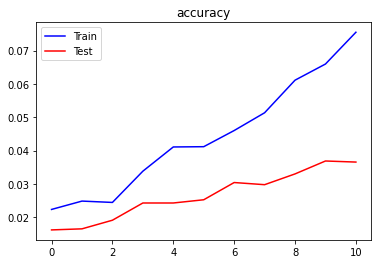

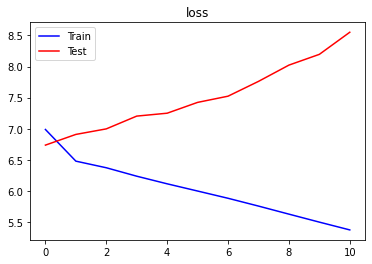

In [43]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

Строим тест генератора

In [55]:
# начальная строка
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "She is my girl, I see in"
next_words = 15
# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	print(token_list)
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
	predicted = model.predict_classes(token_list, verbose=0)
  # 
	output_word = ""
	# добавим новое слово в последовательность
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

[591, 18, 5, 352, 393]
[591, 18, 5, 352, 393, 32]
[591, 18, 5, 352, 393, 32, 170]
[591, 18, 5, 352, 393, 32, 170, 3]
[591, 18, 5, 352, 393, 32, 170, 3, 212]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[591, 18, 5, 352, 393, 32, 170, 3, 212, 145]
[591, 18, 5, 352, 393, 32, 170, 3, 212, 145, 386]
[591, 18, 5, 352, 393, 32, 170, 3, 212, 145, 386, 165]
[591, 18, 5, 352, 393, 32, 170, 3, 212, 145, 386, 165, 196]
[591, 18, 5, 352, 393, 32, 170, 3, 212, 145, 386, 165, 196, 206]
[591, 18, 5, 352, 393, 32, 170, 3, 212, 145, 386, 165, 196, 206, 736]
[591, 18, 5, 352, 393, 32, 170, 3, 212, 145, 386, 165, 196, 206, 736, 411]
[591, 18, 5, 352, 393, 32, 170, 3, 212, 145, 386, 165, 196, 206, 736, 411, 411]
[591, 18, 5, 352, 393, 32, 170, 3, 212, 145, 386, 165, 196, 206, 736, 411, 411, 736]
[591, 18, 5, 352, 393, 32, 170, 3, 212, 145, 386, 165, 196, 206, 736, 411, 411, 736, 736]
Help me Obi Wan Kenobi, you're my only hope doth youth to woe days wrong dead lie kind survey spent spent survey survey survey


То что видим = зацикливание после 3-го добавленного слова (survey)


Посмотрим на предсказание через вероятные ответы (не олно слово имеет большую вероятность)

In [56]:
y_p=model.predict(token_list)

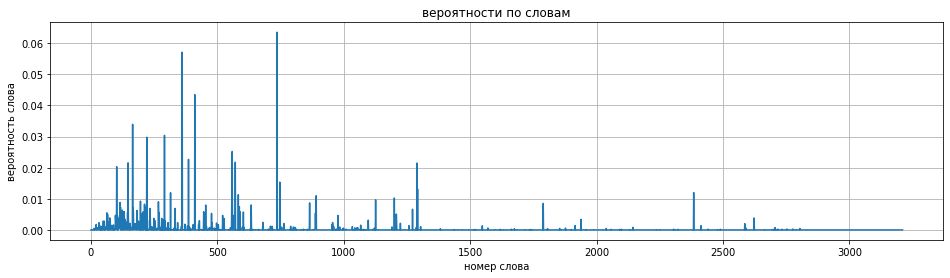

In [57]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [60]:
ind_prob=np.where(y_p[0,:]>0.0410)[0]
ind_prob

array([361, 411, 736])

In [61]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

light  :  0.0571222
spent  :  0.043461457
survey  :  0.0635275


In [63]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "She is my girl, I see in"
next_words = 15
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  #predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""
  y_p=model.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[591, 18, 5, 352, 393]
[591, 18, 5, 352, 393, 32]
[591, 18, 5, 352, 393, 32, 110]
[591, 18, 5, 352, 393, 32, 110, 18]
[591, 18, 5, 352, 393, 32, 110, 18, 165]
[591, 18, 5, 352, 393, 32, 110, 18, 165, 123]
[591, 18, 5, 352, 393, 32, 110, 18, 165, 123, 251]
[591, 18, 5, 352, 393, 32, 110, 18, 165, 123, 251, 98]
[591, 18, 5, 352, 393, 32, 110, 18, 165, 123, 251, 98, 97]
[591, 18, 5, 352, 393, 32, 110, 18, 165, 123, 251, 98, 97, 98]
[591, 18, 5, 352, 393, 32, 110, 18, 165, 123, 251, 98, 97, 98, 119]
[591, 18, 5, 352, 393, 32, 110, 18, 165, 123, 251, 98, 97, 98, 119, 33]
[591, 18, 5, 352, 393, 32, 110, 18, 165, 123, 251, 98, 97, 98, 119, 33, 21]
[591, 18, 5, 352, 393, 32, 110, 18, 165, 123, 251, 98, 97, 98, 119, 33, 21, 261]
[591, 18, 5, 352, 393, 32, 110, 18, 165, 123, 251, 98, 97, 98, 119, 33, 21, 261, 23]
Help me Obi Wan Kenobi, you're my only hope doth show me dead ill deeds new day new must do be gone all me


"Помогите мне, Оби Ван Кеноби, ты моя единственная надежда, покажи мне смертельные злые дела, новый день, новый день должен уйти, все я"